In [62]:
import os
import time
import pickle
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
import pandas as pd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler


os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [19]:
lowess = sm.nonparametric.lowess

In [214]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [80]:

def log_tick_formatter(val, pos=None):
    return f"$10^{{{np.round(val, 1)}}}$"


@np.vectorize
def bgs_rec(mu, s, r, L):
    return np.exp(-L * mu/(s*(1+(1-s)*r/s)**2))

@np.vectorize
def bgs_segment(mu, s, rf, rbp, L):
    r = rbp*L
    a = -s*mu*L
    b = (1-s)**2 # rf^2 terms
    c = 2*s*(1-s)+r*(1-s)**2 # rf terms
    d = s**2 + r*s*(1-s) # constant terms
    return np.exp(a / (b*rf**2 + c*rf + d))

In [4]:
bgs_rec(1e-8, 1e-3, 1e-8, 1e3)

array(0.99005003)

## Data

In [397]:
sim_data = np.load('../data/slim_sims/B_data.npz', allow_pickle=True)

In [399]:
# for extracting columns (more safely than remembering indices
def index_cols(cols):
    index = {c: i for i, c in enumerate(cols)}
    def get(*args):
        return tuple(index[c] for c in args)
    return get

Xcols = index_cols(sim_data['features'])
ycols = index_cols(sim_data['targets'])
sim_data['features'], sim_data['targets']

(array(['N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'], dtype='<U7'),
 array(['pi', 'Bhat', 'Ef', 'Vf', 'load'], dtype='<U4'))

In [377]:
assert(len(sim_data['features']) == sim_data['X'].shape[1])

In [384]:
Xo, yo = np.array(sim_data['X']), sim_data['y']

In [385]:
# how strong is selection?
(X[:, 1] > 1e-3).mean()

0.669124136856861

To be aligned with classic BGS theory, let's parameterize the heterozygous effect as $sh$. We build up our training dataset:

In [402]:
X = np.hstack((Xo[:, Xcols('mu')], np.prod(Xo[:, Xcols('s', 'h')], axis=1)[:, None], Xo[:, Xcols('recfrac')]))
X

array([[5.3880e-06, 3.6275e-03, 1.9010e-08],
       [6.3350e-06, 6.1650e-04, 3.3870e-08],
       [6.4200e-06, 2.8550e-03, 1.4250e-07],
       ...,
       [5.2750e-07, 8.6100e-03, 1.1690e-07],
       [6.7120e-06, 2.1320e-04, 4.1970e-08],
       [3.2460e-06, 9.6400e-05, 5.0280e-07]])

Now extract the target, $\hat{B}$.

In [400]:
y = y[:, ycols('Bhat')]

Divide up the training/test sets

In [407]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

# note we have separate scalers for train/test to avoid data leakage
X_train_scaler = StandardScaler().fit(X_train)
X_test_scaler = StandardScaler().fit(X_test)

X_train_normalized = X_train_scaler.transform(X_train)
X_test_normalized = X_test_scaler.transform(X_test)

In [488]:
# range of X?
X_bounds = np.vstack((X_train.min(axis=0), X_train.max(axis=0))).T
X_bounds

array([[5.8440e-09, 9.0970e-06],
       [5.0000e-05, 4.9995e-02],
       [1.0010e-08, 9.9970e-07]])

In [495]:
np.logspace(-4, -1, 10)

array([0.0001    , 0.00021544, 0.00046416, 0.001     , 0.00215443,
       0.00464159, 0.01      , 0.02154435, 0.04641589, 0.1       ])

In [496]:
def grid_maker(bounds, scales=None):
    orig_scales = scales
    def func(n, scales=None):
        if scales is None:
            scales = orig_scales
        grids = []
        for i, (lower, upper) in enumerate(bounds):
            if scales is None or scales[i] == 'linear':
                grids.append(np.linspace(lower, upper, n))
            elif scales[i] == 'log':
                grids.append(np.logspace(lower, upper, n))
            else:
                raise ValueError()
        return grids
    return func

X_new_grids = grid_maker(X_bounds, ('log', 'log', 'log'))(10)
X_new_grids

[array([1.00000001, 1.00000234, 1.00000467, 1.00000699, 1.00000932,
        1.00001164, 1.00001397, 1.00001629, 1.00001862, 1.00002095]),
 array([1.00011514, 1.01297667, 1.02600361, 1.03919807, 1.05256222,
        1.06609823, 1.07980831, 1.09369471, 1.10775968, 1.12200554]),
 array([1.00000002, 1.00000028, 1.00000053, 1.00000078, 1.00000104,
        1.00000129, 1.00000154, 1.0000018 , 1.00000205, 1.0000023 ])]

In [409]:
def network(n64=2, n32=6, output_activation='sigmoid'):
    # build network
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(3,)))
    #model.add(layers.BatchNormalization(axis=1))
    for i in range(n64):
        model.add(layers.Dense(64, activation='elu'))
        #model.add(layers.Dropout(0.2))
    for i in range(n32):
        model.add(layers.Dense(32, activation='elu'))
        #model.add(layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation=output_activation))
    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['MeanAbsoluteError'],
        )
    return model

In [410]:
model = network(output_activation='sigmoid')
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                   patience=50, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = model.fit(X_train_normalized, y_train, 
                    validation_split=0.2, 
                    #validation_data=(X_test_normalized, y_test),
                    batch_size=64, epochs=500, verbose=0, callbacks=[es, tqdm_callback])

Training:   0%|                                                                                               …

Restoring model weights from the end of the best epoch: 102.
Epoch 00152: early stopping


In [417]:
predict = model.predict(X_test_normalized).squeeze()

In [418]:
idx = np.abs(predict - 1) < 0.01
((predict[idx] - y_test[idx])**2).mean()

0.23519816887372044

In [419]:
predict.max()

0.99951696

In [420]:
2/ 9

0.2222222222222222

In [423]:
y_test.shape, predict.shape

((5779, 1), (5779,))

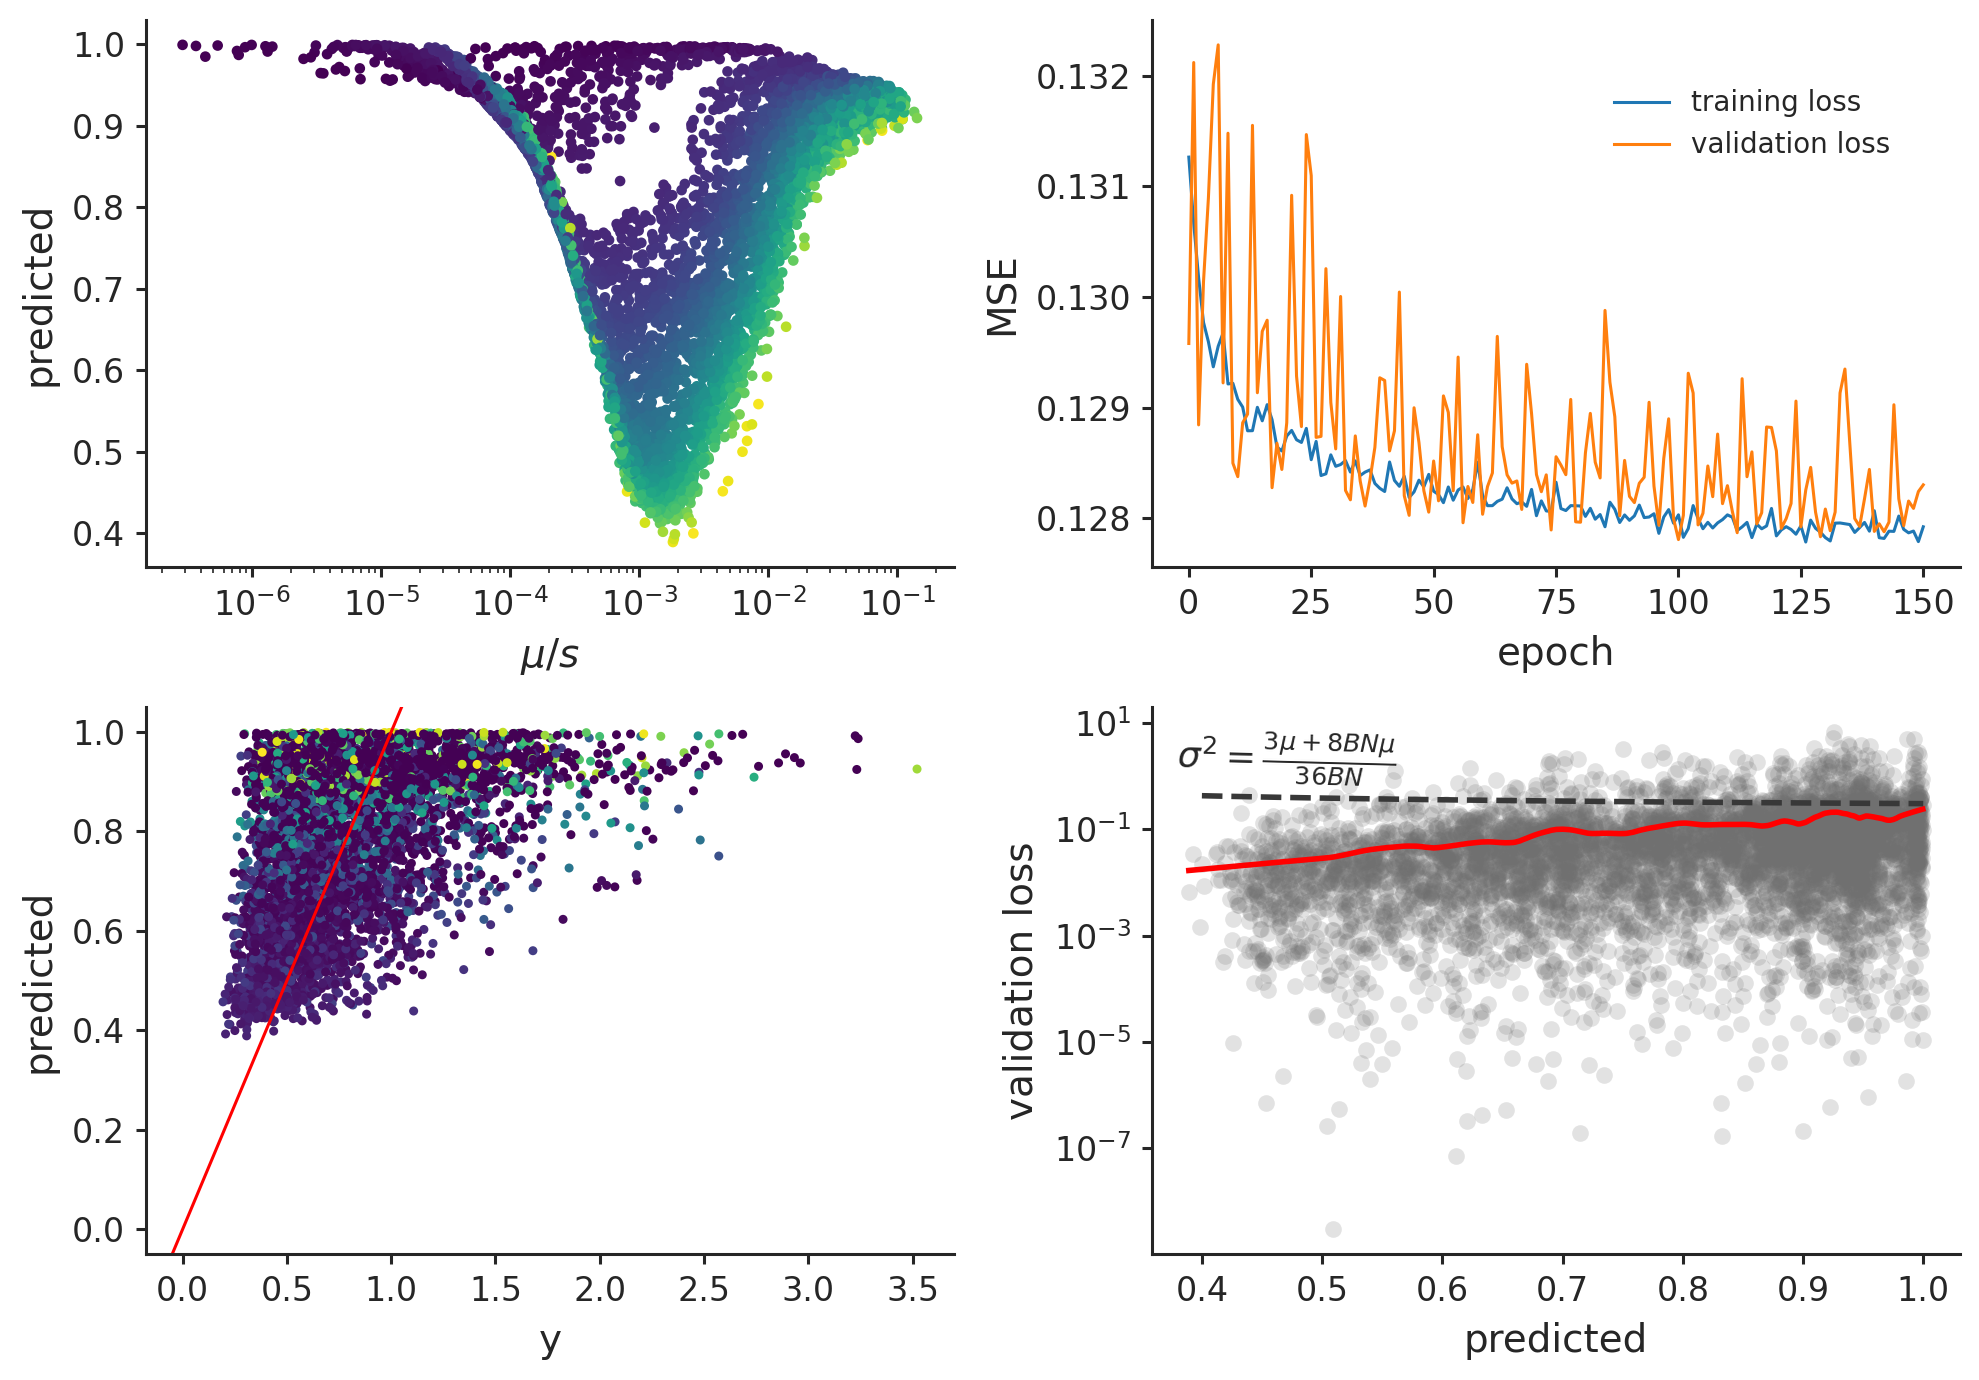

In [459]:
y_theory = bgs_rec(X_test[:, 1], X_test[:, 0], X_test[:, 2], 1000)

mu_test, s_test, recrac_test = X_test.T
rate = mu_test/s_test

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))

norm = plt.Normalize(np.min(mu_test), np.max(mu_test))

ax1.scatter(rate, predict, c=mu_test, cmap='viridis', s=8)
ax1.set_xlabel("$\mu/s$")
ax1.set_ylabel("predicted")
ax1.semilogx()
#cax1 = fig.add_axes([0.27, 0.8, 0.5, 0.05])
#fig.colorbar(cmap=cm.viridis, cax=cax1, orientation='horizontal')


ax3.scatter(y_test, predict, c=X_test[:, 1], s=5)
ax3.axline((0, 0), slope=1, c='r')
ax3.set_xlabel('y')
ax3.set_ylabel('predicted')

ly = (predict - y_test.squeeze())**2
lX = predict
ax4.scatter(lX, ly, color='0.44', 
            linewidth=0, edgecolor='black', alpha=0.2)
#ax4.set_ylim(-0.1, 3)
z = lowess(ly, lX, frac= 1/10, it=0)
ax4.plot(z[:, 0], z[:, 1], c='r', linewidth=2)

# the lowess fit was sensitive to it=0; this shows that the it=0 
# case is nearly identical to OLS, e.g. right thing to do
#mod = sm.OLS(ly, sm.add_constant(lX))
#res = mod.fit()
#lX_new = sm.add_constant(np.linspace(0.4, 1, 100))
#ax4.plot(lX_new, res.predict(lX_new), c='g')

xnew = np.linspace(0.4, 1, 100)
def B_var_limit(N, mu=1):
    return (3*mu + 8*N*mu**2)/(36*N)
ax4.plot(xnew, B_var_limit(xnew), c='0.22', linewidth=2, linestyle='dashed') # Note the 1/2 factor — see sim_power.ipynb! TODO
ax4.text(0.03, 0.88, "$\sigma^2 = \\frac{3 \mu + 8 B N \mu}{36 B N}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.semilogy()
ax4.set_ylabel('validation loss')
ax4.set_xlabel('predicted')

ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
#ax2.set_ylim((0, 1))
ax2.legend()
plt.tight_layout()

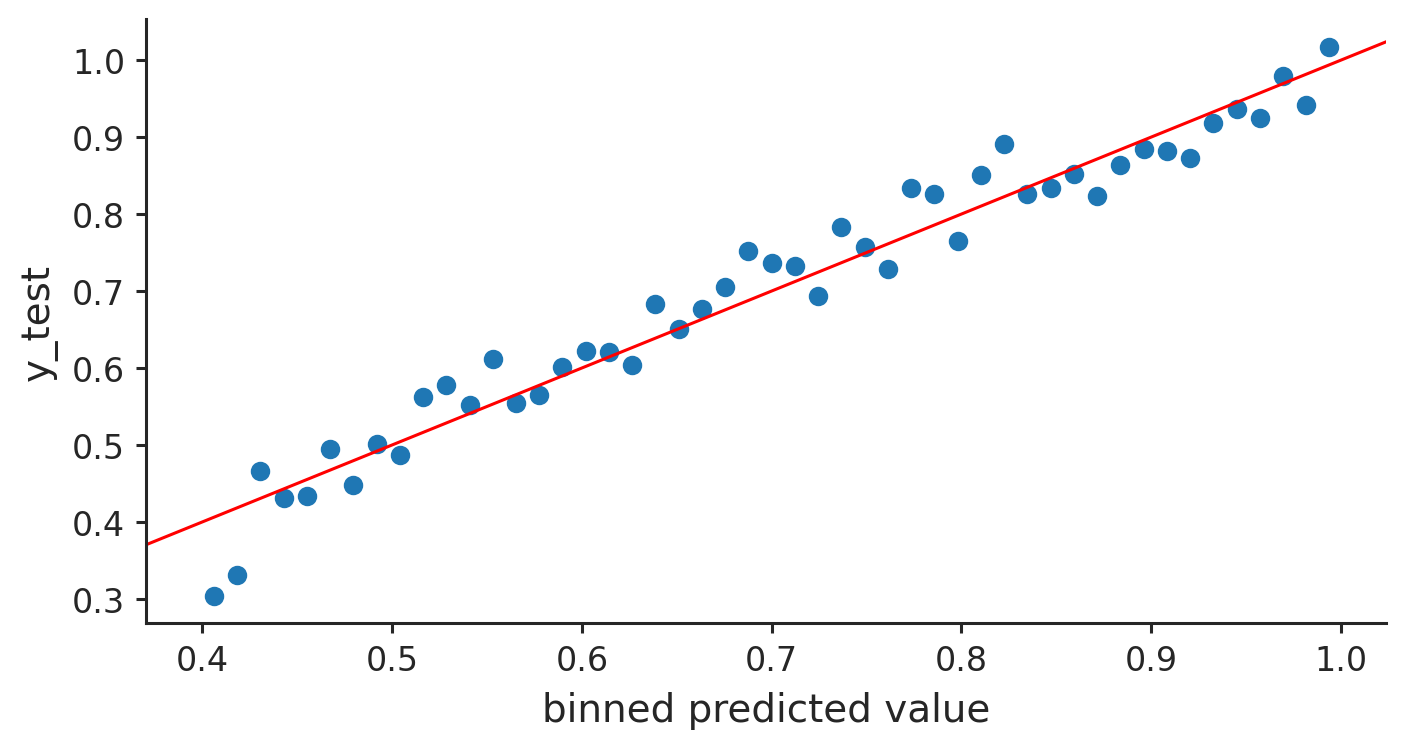

In [322]:
bins = np.linspace(0.4, 1, 50)
ytest_bins = stats.binned_statistic(predict, y_test, bins=bins)
fig, ax = plt.subplots()
ax.scatter(0.5*(bins[1:] + bins[:-1]), ytest_bins.statistic)
ax.set_ylabel('y_test')
ax.set_xlabel('binned predicted value')
ax.axline((0.4, 0.4), slope=1, c='r')

In [67]:
n = 50_000
sn = 10**np.linspace(-4, -1, n)
mun = 10**np.linspace(-9, -5, n)
rn = 10**np.linspace(-8, -6, n)
#X1, X2, X3 = np.meshgrid(sn, mun, rn)
# s, mu, recfrac
X1, X2, X3 = 10**np.random.uniform(-4, -1, n), np.random.uniform(5.5e-9, 1e-7, n),  np.repeat(2e-8, n)

In [68]:
Xnew = np.stack((X1.flatten(), X2.flatten(), X3.flatten())).T

predict_new = model.predict(X_scaler.transform(Xnew)).flatten()

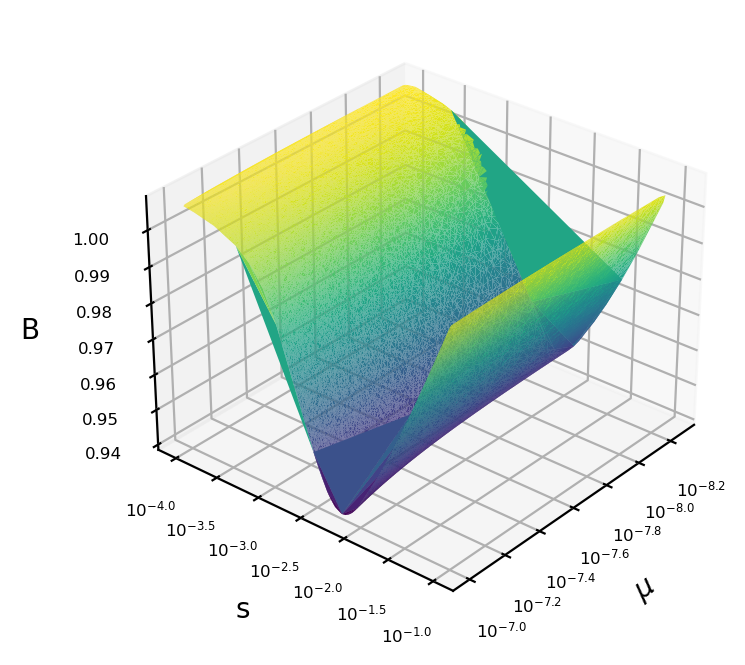

In [69]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_trisurf(np.log10(X2), np.log10(X1), predict_new, cmap='viridis')
#ax.plot_trisurf(np.log10(X2), np.log10(X1), theory_new, cmap='inferno_r')

#ax.scatter(X[:, 3], X[:, 1], y[:, 1], c=y[:, 1], cmap='viridis')
ax.view_init(30, 40)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_zlabel('B')
ax.set_ylabel('s')
ax.set_xlabel('$\mu$')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))


In [462]:
def surface_plot(x, y, z, xlabel=None, ylabel=None, 
                 scale=None, ncontour=None, contour_ndigits=2, 
                 figax=None, **kwargs):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    ax.pcolormesh(x, y, z, **kwargs)
    if scale is not None and scale != 'linear':
        avail_scales = ('loglog', 'semilogx', 'semilogy')
        if not scale in avail_scales:
            raise ValueError(f"scale must be one of {', '.join(avail_scales)}")
        getattr(ax, scale)()
    if ncontour is not None:
        cs = ax.contour(x, y, z, ncontour, colors='0.44', linestyles='dashed', linewidths=0.8, alpha=0.4)
        ax.clabel(cs, inline=True, fontsize=8)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)    
    return fig, ax 

In [483]:
n = 100
sn = 10**np.linspace(-4, -1, n)
mun = 10**np.linspace(-9, -5, n)
X1, X2 = np.meshgrid(sn, mun)


ncontour = np.linspace(0.4, 0.96, 8)

Z = bgs_segment(X2, X1, 2e-8, 1e-8, 1000)

Zp = model.predict(X_test_scaler.transform(Xnew)).reshape(X1.shape)


fig, ax = plt.subplots(ncols=2)

surface_plot(sn, mun, Z, scale='loglog', xlabel="s", ylabel="$\mu$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(sn, mun, Zp, scale='loglog', xlabel="s", ylabel="$\mu$", ncontour=ncontour, figax=(fig, ax[1]))

ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

ValueError: X has 2 features, but StandardScaler is expecting 3 features as input.

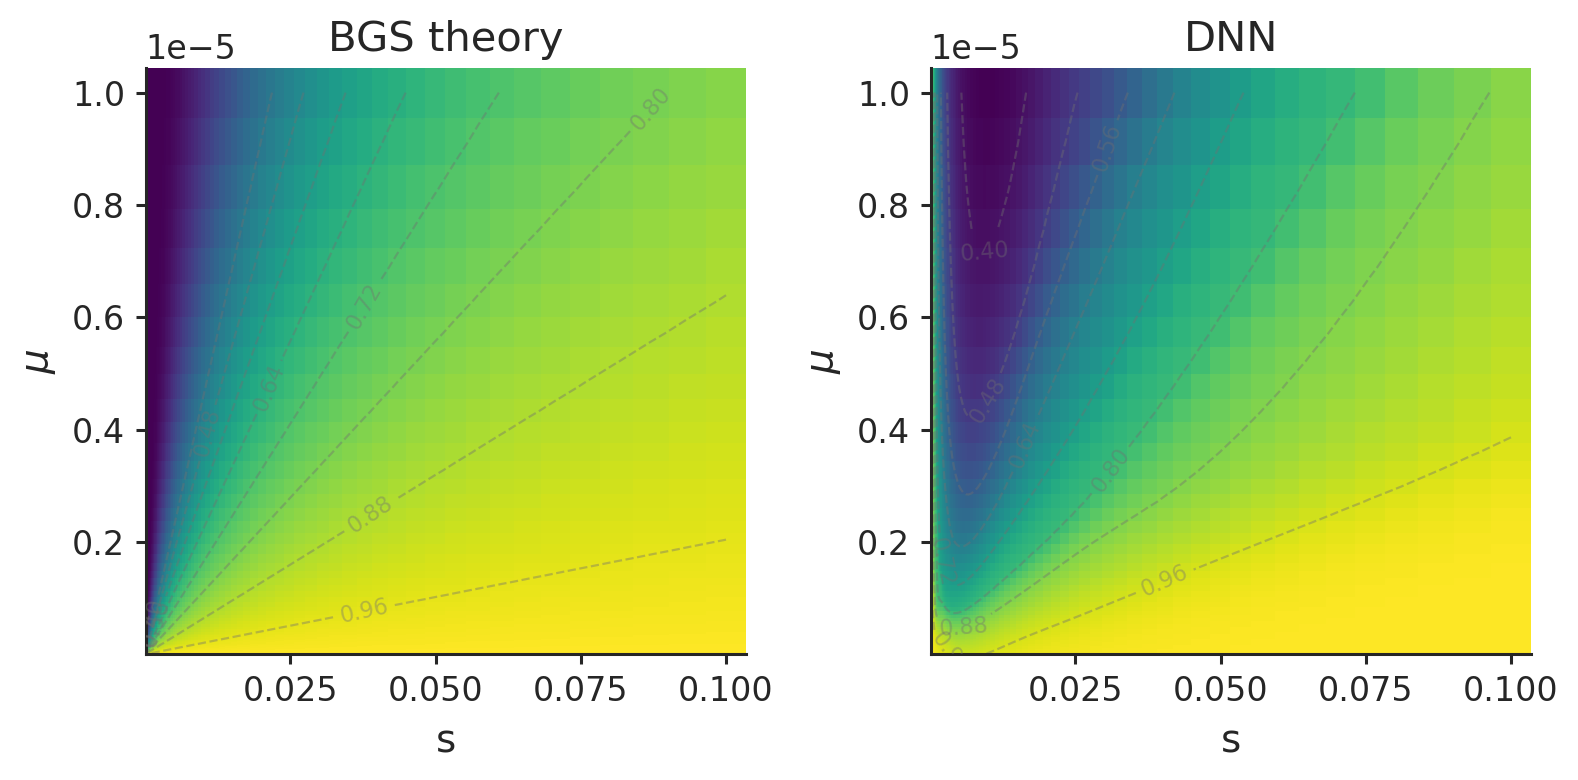

In [374]:
fig, ax = plt.subplots(ncols=2)

surface_plot(sn, mun, Z, xlabel="s", ylabel="$\mu$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(sn, mun, Zp, xlabel="s", ylabel="$\mu$", ncontour=ncontour, figax=(fig, ax[1]))

ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()


(<Figure size 600x600 with 1 Axes>, <AxesSubplot:xlabel='s', ylabel='$\\mu$'>)

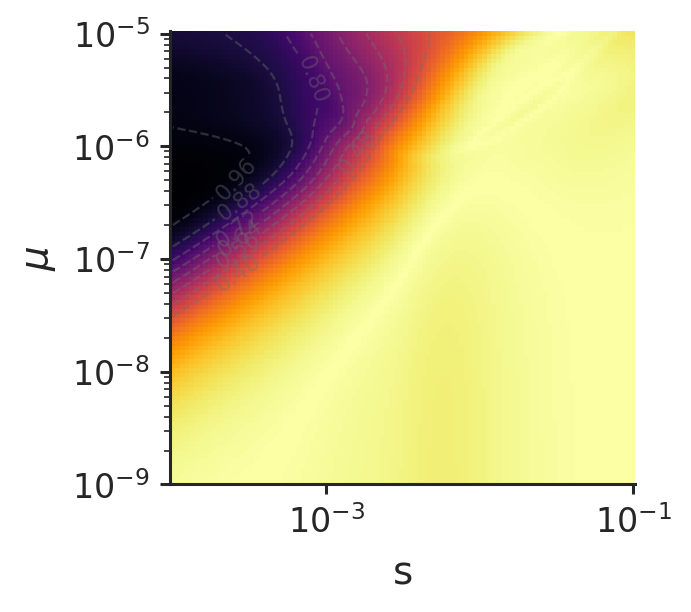

In [477]:
Zdiff = np.abs(Zp - Z)
figax = plt.subplots(figsize=(3, 3))
surface_plot(sn, mun, Zdiff, scale='loglog', xlabel="s", ylabel="$\mu$", ncontour=ncontour, 
                      cmap='inferno_r', figax=figax)

In [283]:
model.evaluate(X_test_normalized, y_test)

61/61 [==============================] - 0s 2ms/step - loss: 0.1419 - mean_absolute_error: 0.2605


[0.14185424149036407, 0.2605266869068146]

In [55]:
model.evaluate(X_test_normalized, y_test)

3125/3125 [==============================] - 5s 2ms/step - loss: 0.1446 - mean_absolute_error: 0.2683


[0.1446310430765152, 0.2682616710662842]

In [284]:
np.abs(predict.flatten() - y_test.flatten()).mean(), np.abs(predict.flatten() - y_theory.flatten()).mean()

(0.26052667821272607, 0.40324143167388765)

In [171]:
np.abs(predict.flatten() - y_test.flatten()).mean(), np.abs(predict.flatten() - y_theory.flatten()).mean()

(5.392334013709564e-06, 0.9286115050067685)

(array([  86., 1026., 3738., 6127., 5709., 3269., 1272.,  295.,   27.,
           8.]),
 array([-0.62505611, -0.48181238, -0.33856864, -0.1953249 , -0.05208117,
         0.09116257,  0.23440631,  0.37765004,  0.52089378,  0.66413752,
         0.80738125]),
 <BarContainer object of 10 artists>)

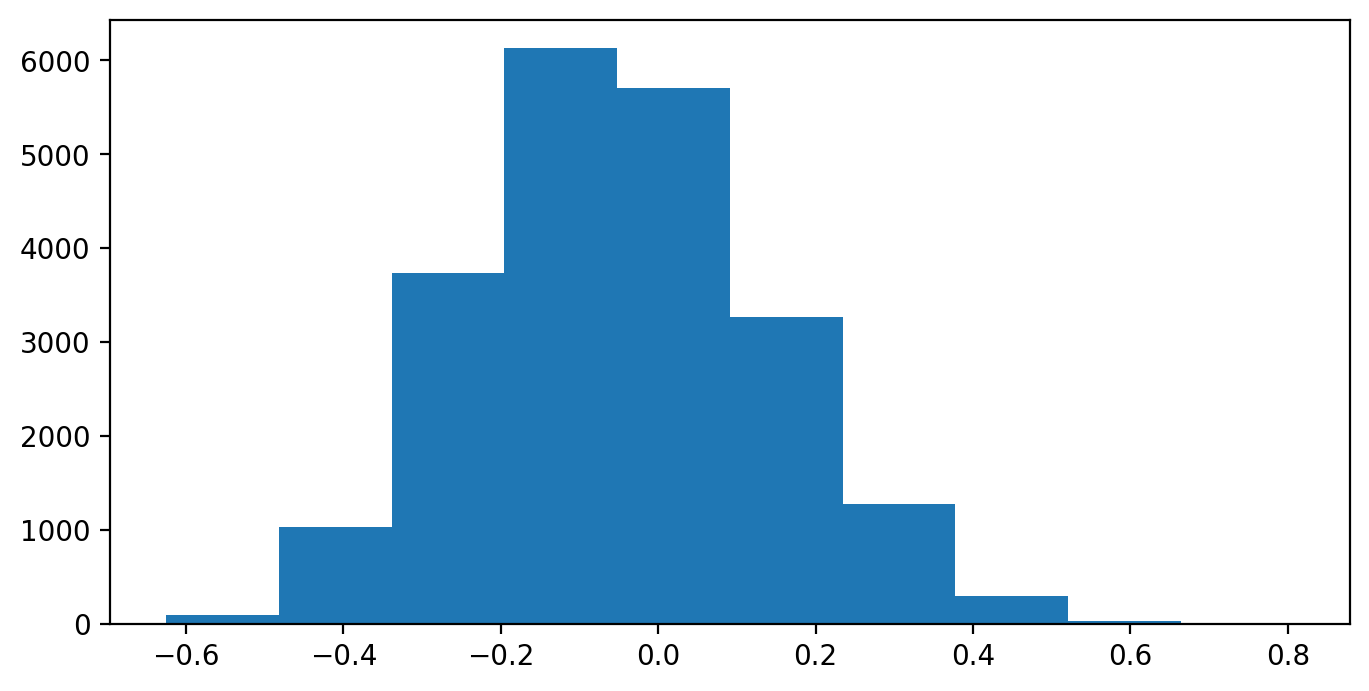

In [202]:
fig, ax = plt.subplots()
ax.hist(np.log10(y[:, 1].flatten()))

Text(0, 0.5, 'B')

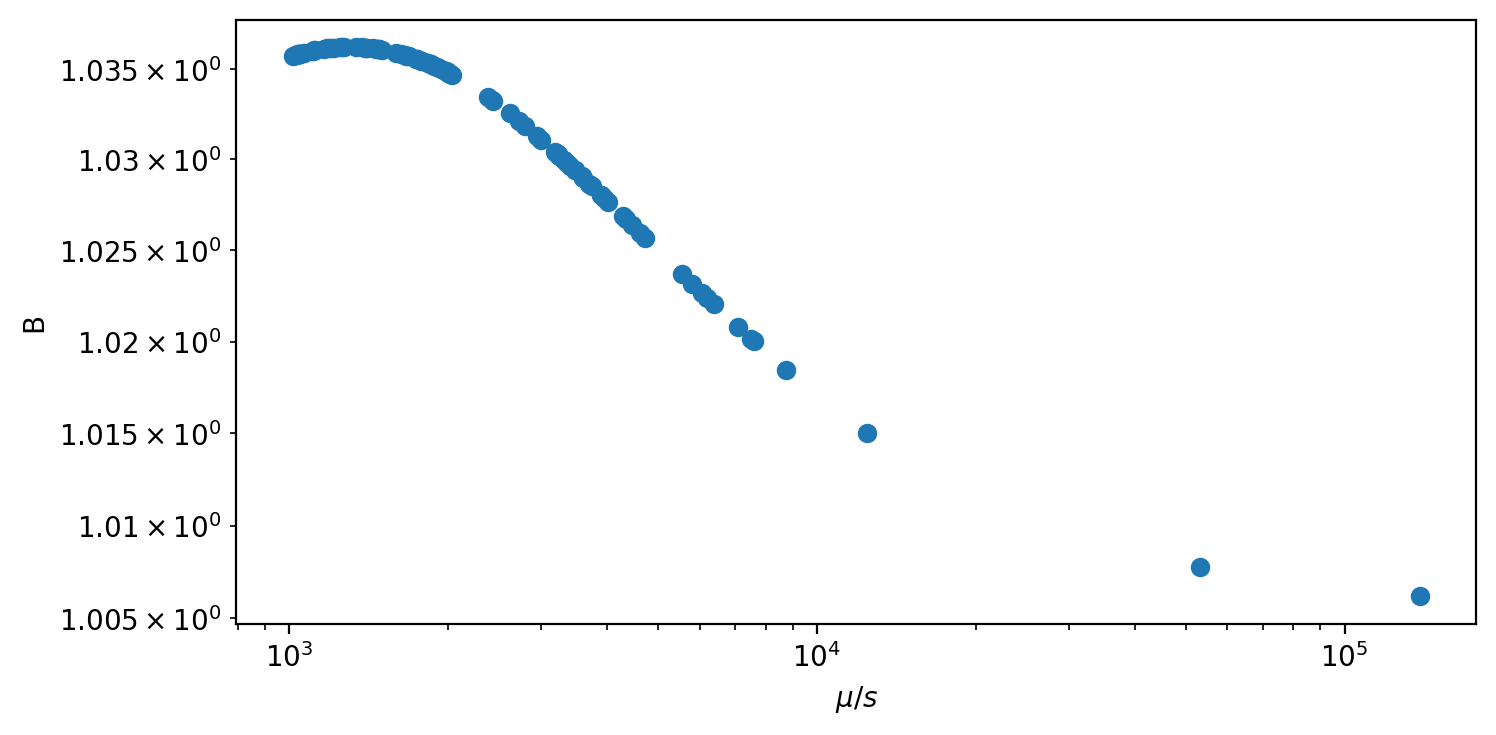

In [245]:
n = 100
mu = np.random.uniform(1e-8, 1e-8, n)
s = np.random.uniform(1e-6, 1e-1, n)
#rbp = np.random.uniform(1e-7, 1e-9, n)
rbp = np.repeat(1e-8, n)
#recfrac = np.random.uniform(1e-7, 1e-3, n)
recfrac = np.repeat(1e-8, n)
#L = np.random.uniform(10, 100_000, n)
L = np.repeat(1000, n)
#N = np.random.uniform(50, 10_000, n)
N = np.repeat(100, n)
#xnew = np.array((mu, s, rbp, N, L)).T
#'N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'
xnew = np.array((N, s, mu, recfrac, rbp, L)).T
rate = xnew[:, 0]/xnew[:, 1]
fig, ax = plt.subplots()
ax.scatter(rate, model.predict(X_scaler.transform(xnew)))
#ax.scatter(rate, bgs_rec(mu, s, rbp, L))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mu/s$')
ax.set_ylabel('B')

In [105]:
tf.reduce_mean(np.abs(predict.flatten() - y_theory.flatten()))

<tf.Tensor: shape=(), dtype=float64, numpy=0.007151165998975198>

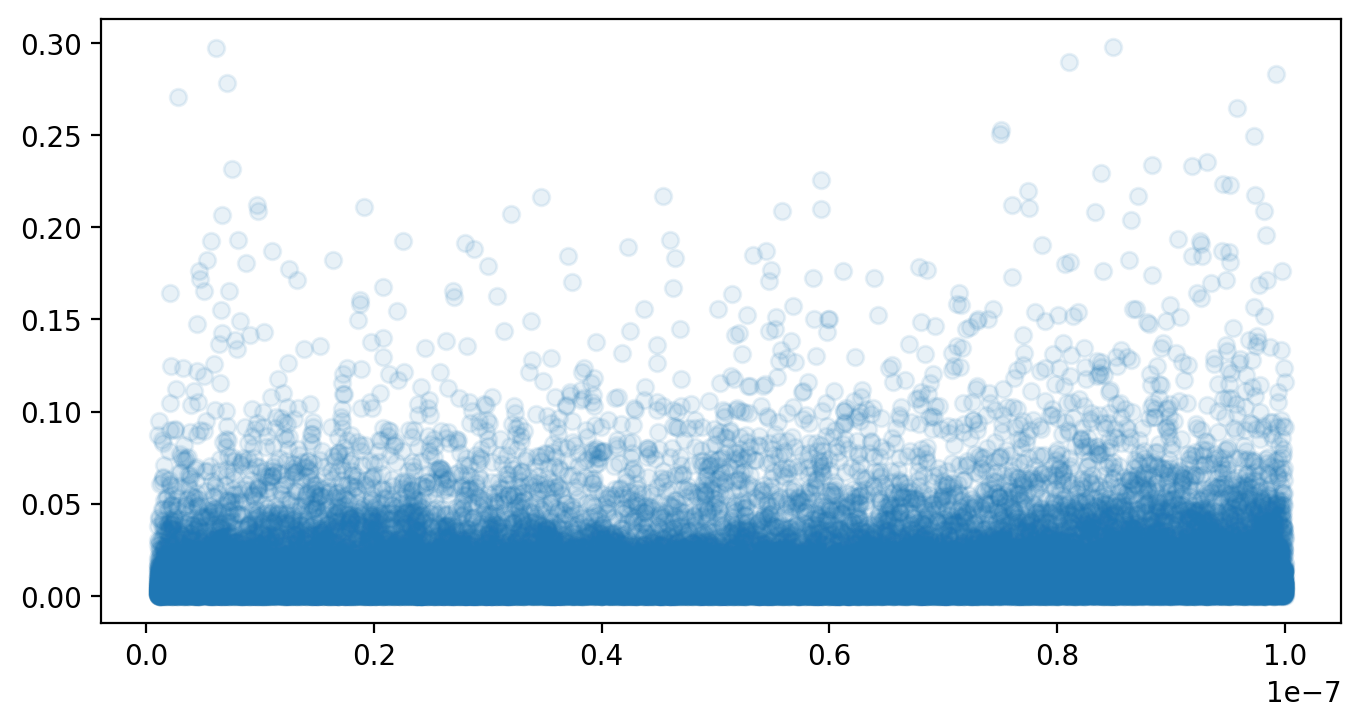

In [ ]:
plt.scatter(X_test[:, 3], np.abs(predict.flatten() - y_theory.flatten()), alpha=0.1)

In [212]:
dat = np.load('/home/vsb/projects/bprime/data/slim_sims/B_data.npz')

In [213]:
X, y, features = dat['X'], dat['y'], dat['features']

In [214]:
X, features

(array([[1.000e+03, 3.560e-02, 5.000e-01, ..., 1.714e-08, 1.100e-08,
         1.000e+03],
        [1.000e+03, 5.710e-03, 5.000e-01, ..., 1.425e-07, 1.100e-08,
         1.000e+03],
        [1.000e+03, 3.101e-03, 5.000e-01, ..., 7.648e-08, 1.100e-08,
         1.000e+03],
        ...,
        [1.000e+03, 4.264e-04, 5.000e-01, ..., 4.197e-08, 1.100e-08,
         1.000e+03],
        [1.000e+03, 1.066e-02, 5.000e-01, ..., 8.634e-08, 1.100e-08,
         1.000e+03],
        [1.000e+03, 1.393e-02, 5.000e-01, ..., 3.009e-08, 1.100e-08,
         1.000e+03]]),
 array(['N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'], dtype='<U7'))

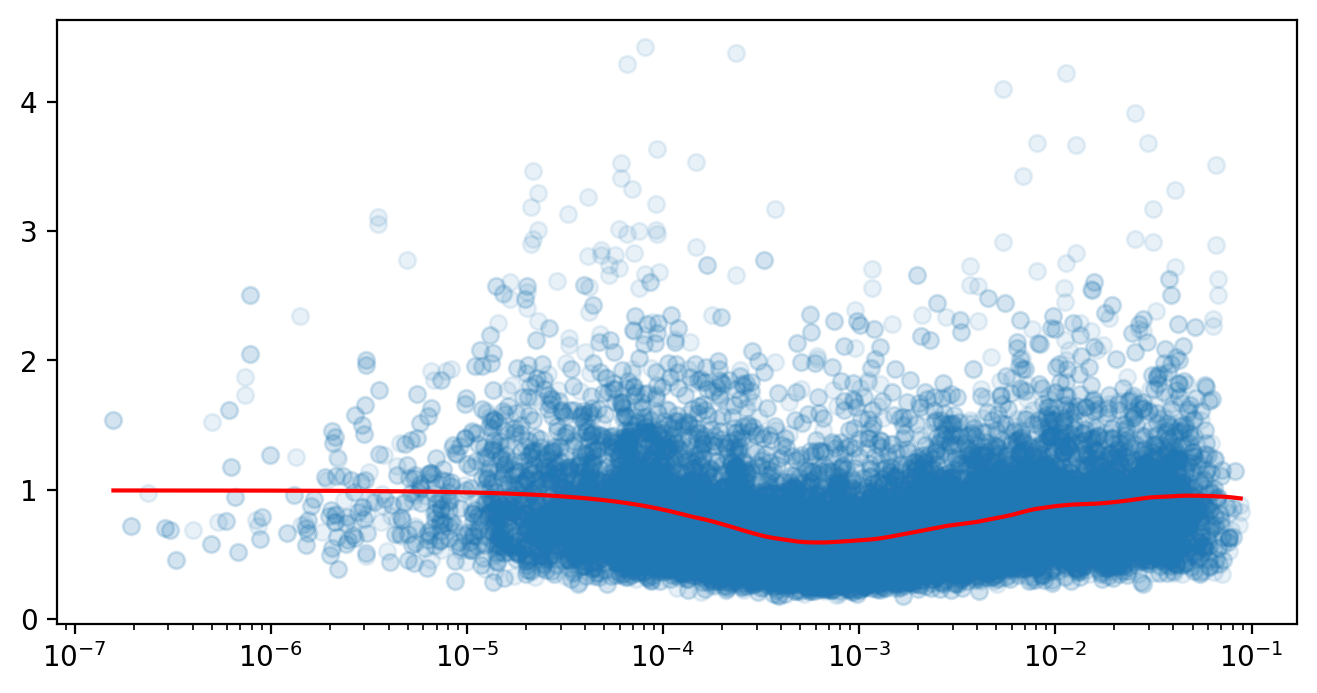

In [215]:
idx = X[:, 4] < 1
rate = X[idx, 3]/X[idx, 1]
yy = y[idx, 1]
fig, ax = plt.subplots()
ax.scatter(rate, yy, alpha=0.1)

z = lowess(yy, rate, frac= 1./3, it=0)
ax.plot(z[:, 0], z[:, 1], c='r')
ax.set_xscale('log')

- make a kernel ridge vs DNN predicted surface plot
- weak impact on B can be caused by both BGS and weak selection
- is the mulitplicative right?


In [216]:
X.shape, y.shape


((19517, 7), (19517, 5))

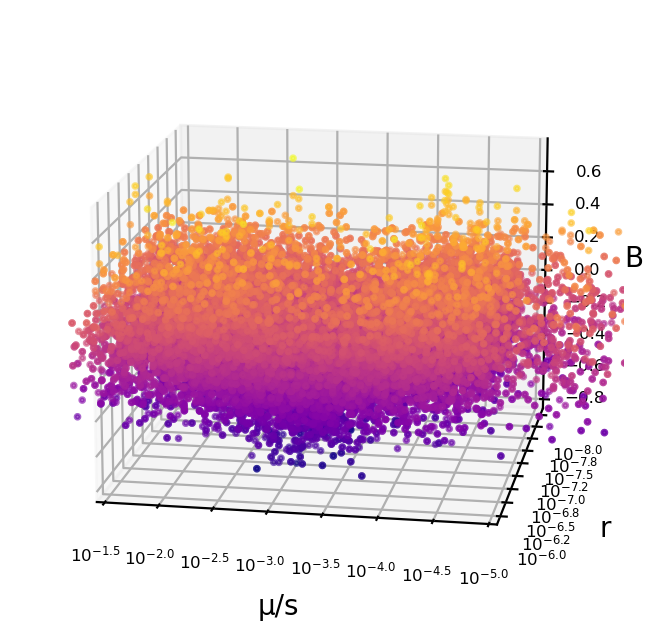

In [479]:

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(np.log10(X[:, 3]/X[:, 1]), np.log10(X[:, 4]), np.log10(y[:, 1]), s=3, c=np.log10(y[:, 1]), alpha=0.6, cmap='plasma')
#ax.scatter(X[:, 3], X[:, 1], y[:, 1], c=y[:, 1], cmap='viridis')

#ax.view_init(5, 270)
ax.view_init(15, 100)
ax.set_xlim(-5, -1.5)
ax.set_xlabel('μ/s')
ax.set_ylabel('r')
ax.set_zlabel('B')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))


In [218]:
from sklearn.kernel_ridge import KernelRidge

In [234]:
krr = KernelRidge(gamma=0.1, kernel='rbf')
features = np.stack((X[:, 3]/X[:, 1], X[:, 4])).T
krrm = krr.fit(features, y[:, 1])

Text(0.5, 0, 'B')

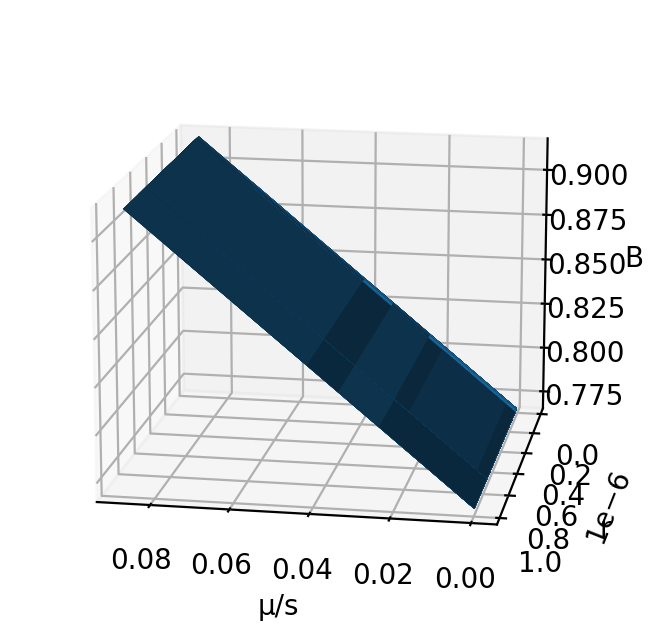

In [235]:
n = 100
xnew = 10**np.random.uniform(-5, -1, n)
ynew = 10**np.random.uniform(-8, -6, n)
Xg, Yg = np.meshgrid(xnew, ynew)
ynew = krrm.predict(np.stack((Xg.flatten(), Yg.flatten())).T).reshape(Xg.shape)

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.scatter(np.log10(X[:, 3]/X[:, 1]), np.log10(X[:, 4]), np.log10(y[:, 1]), s=3, c=y[:, 1], alpha=0.6, cmap='viridis')
#ax.scatter(X[:, 3], X[:, 1], y[:, 1], c=y[:, 1], cmap='viridis')
ax.plot_surface(Xg, Yg, ynew)
#ax.view_init(5, 270)
ax.view_init(15, 100)
#ax.set_xlim(-5, -1.5)
ax.set_xlabel('μ/s')
ax.set_ylabel('r')
ax.set_zlabel('B')
#ax.tick_params(axis='both', which='major', labelsize=6)
#ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
#ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
#ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
